# **Landmark Registration — using the built in MMoCHi function**

**Author:** Daniel Caron

**In this notebook, we walk through how to fine-tune MMoCHi's in-house landmark registration function. This fine-tuning is critical for obtaining well-integrated ADT data. Here, we will focus primarily on correcting landmark detection, as the position of identified landmarks defines how the expression distributions are shifted.**


A note before we begin: landmark registration of ADT data can also be achieved using [ADTnorm in R](https://github.com/yezhengSTAT/ADTnorm) or the [Python wrapper for it](https://github.com/donnafarberlab/ADTnormPy). The functions shown here are specifically designed to work with our in-house landmark registration function, but the concepts described can be applied to any landmark registration based tool.

## **Import packages**

In [1]:
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import mmochi as mmc
import os
plt.rcParams['figure.dpi'] = 150
mmc.log_to_file('landmark_registration')

# Make the data directory if this notebook is not being run in the docs folder
if not os.path.isdir('data'):
    os.mkdir('data')

Set the global default for `batch_key`, so that we don't need to pass it to every function

In [2]:
mmc.BATCH_KEY = 'batch'

## **Downloading and preprocessing the data**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Prior to landmark registration, we should normalize the data using arcsine or log transformations. These transformations should be tuned until you have clear separation of positive and negative populations on bimodal and trimodal markers. Finding the right transformation will aid with landmark registration, thresholding, and interpretability.    
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Here, we will demonstrate landmark registration across three 10X Genomics sequencing runs (pbmc_10k_protein_v3, 5k_pbmc_protein_v3, and pbmc_1k_protein_v3). Landmark registration removes batch effects caused by variable background and signal-to-noise ratio of antibody staining and variable sequencing depth, thus samples that were stained or sequenced separately should be treated as separate batches. In this case, staining was performed separately for each of the sequencing runs. The following function will download the datasets, perform normalization, and format them with the GEX data in the `.X` and the ADT data in the `.obsm['protien']`:

In [3]:
batches = ['pbmc_10k_protein_v3','5k_pbmc_protein_v3','pbmc_1k_protein_v3']
files = ['data/pbmc_10k_protein_v3.h5','data/5k_pbmc_protein_v3.h5','data/pbmc_1k_protein_v3.h5']
urls = ['http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_10k_protein_v3/pbmc_10k_protein_v3_filtered_feature_bc_matrix.h5',
        'http://cf.10xgenomics.com/samples/cell-exp/3.0.2/5k_pbmc_protein_v3/5k_pbmc_protein_v3_filtered_feature_bc_matrix.h5',
        'http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_1k_protein_v3/pbmc_1k_protein_v3_filtered_feature_bc_matrix.h5']
adatas = mmc.utils.preprocess_adatas(files,
                                     backup_urls = urls, log_CP_ADT=1e3, log_CP_GEX=1e4)
adata = anndata.concat(adatas, merge='first', keys=batches,
                       label='batch', index_unique='_')

## **Check how landmark registration performs by default**
Let's begin by running landmark registration with no manual alterations, so that we can see how it performs on every marker/batch:

In [4]:
adata = mmc.landmark_register_adts(adata, data_key='protein')

Running with batch batch


  0%|          | 0/3 [00:00<?, ?it/s]

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Once the landmark registration has run, this code block will plot all the ADTs in alphabetical order. The ADT expression distribution (`'protein'`) and the landmark-registered distributions (`'landmark protein'`) are shown side-by-side for each marker on a 10% subsample of the dataset. Peaks detected are highlighted by small black bars. To identify issues, we're going to carefully inspect the marker distribution before and after landmark registration:

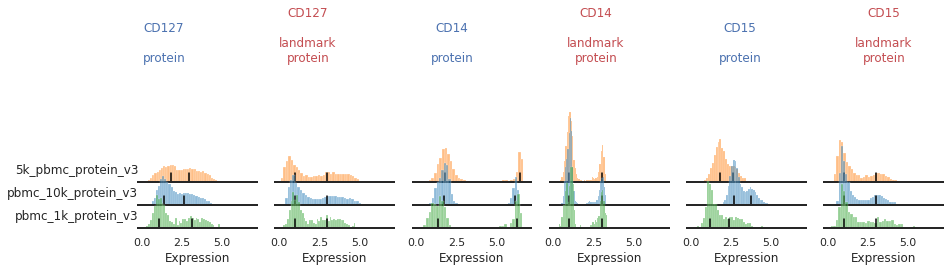

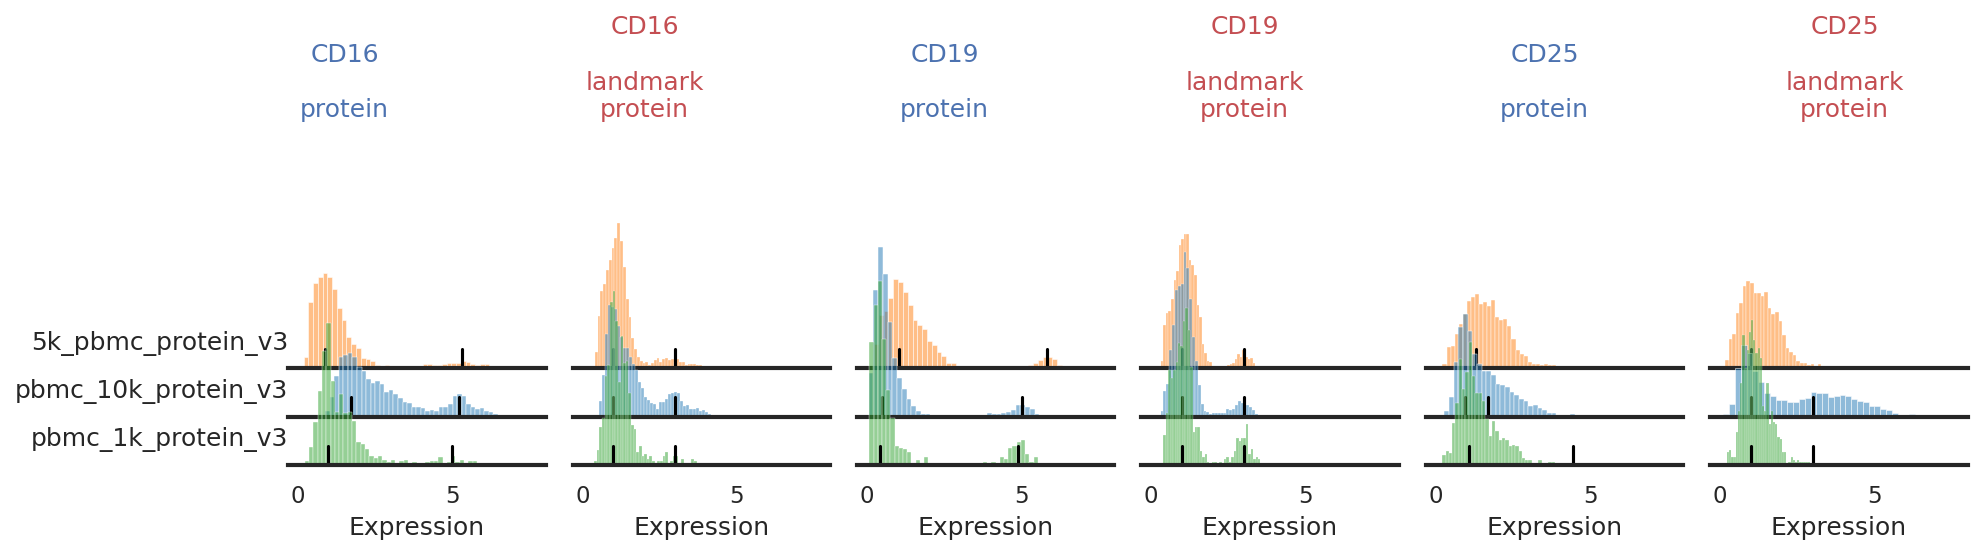

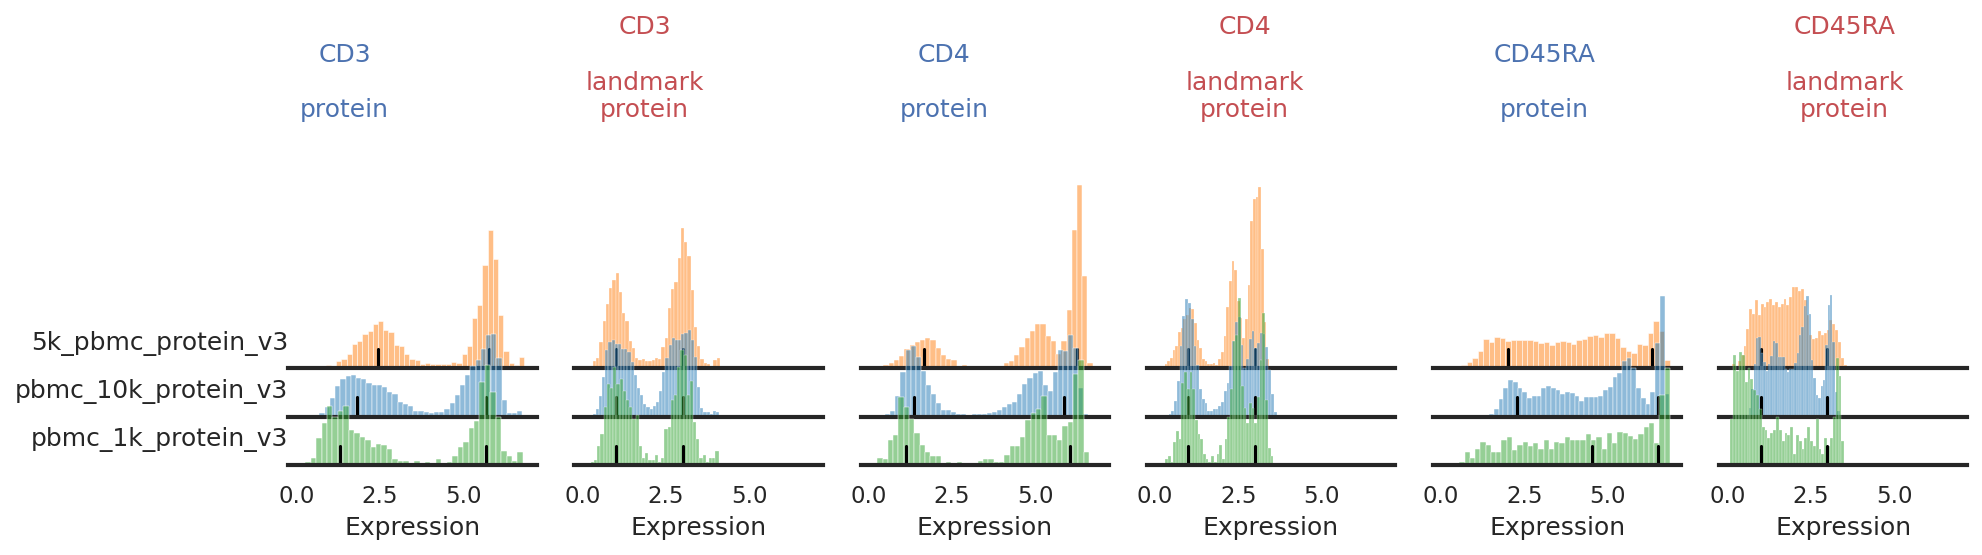

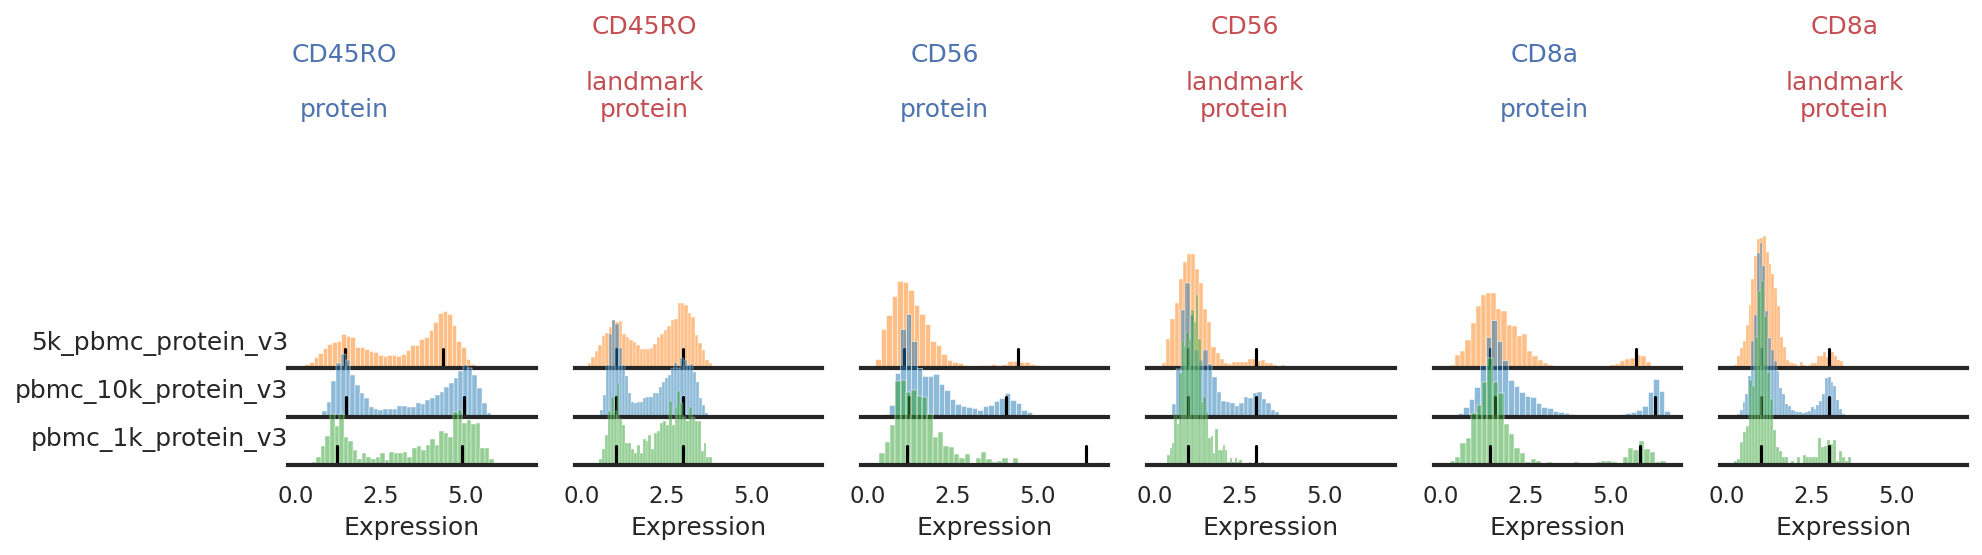

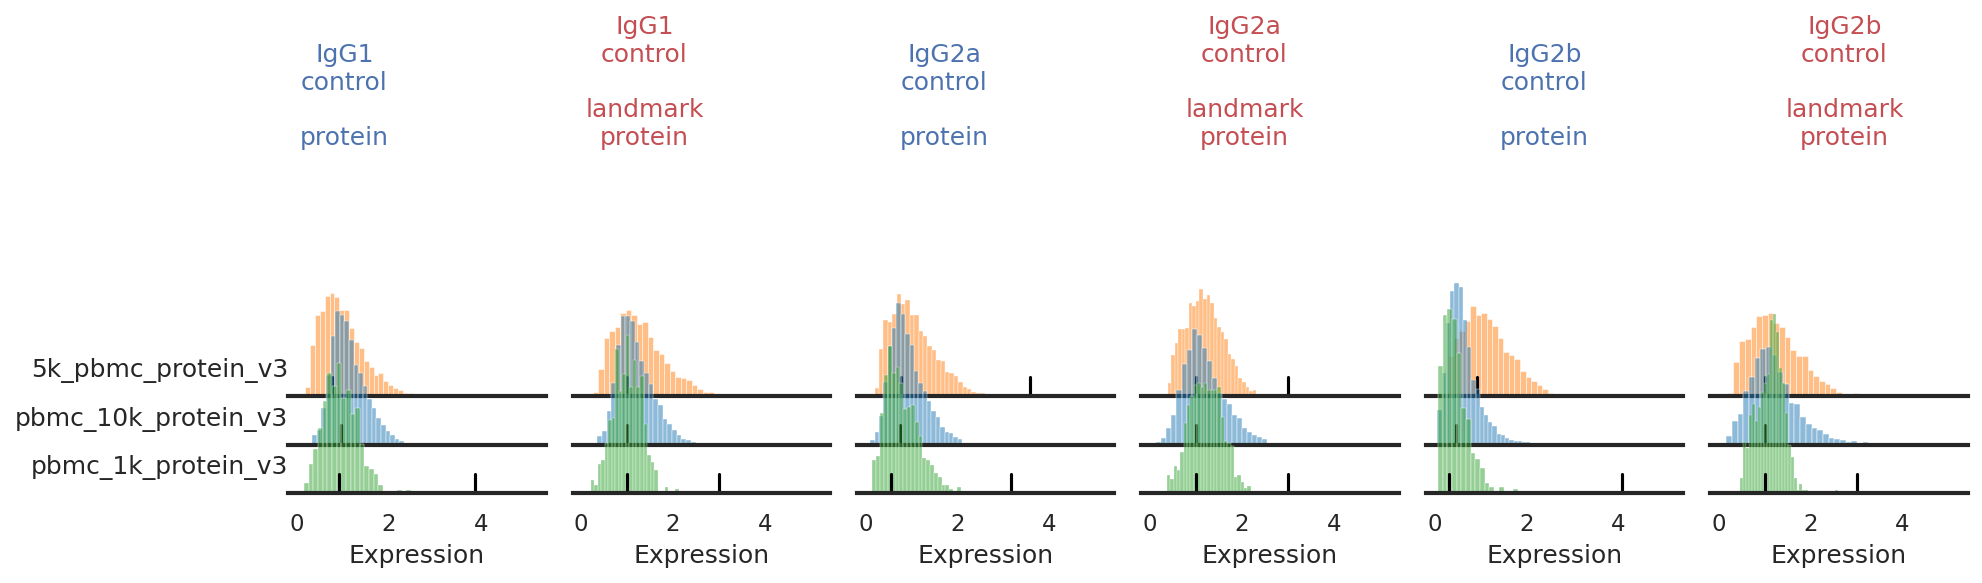

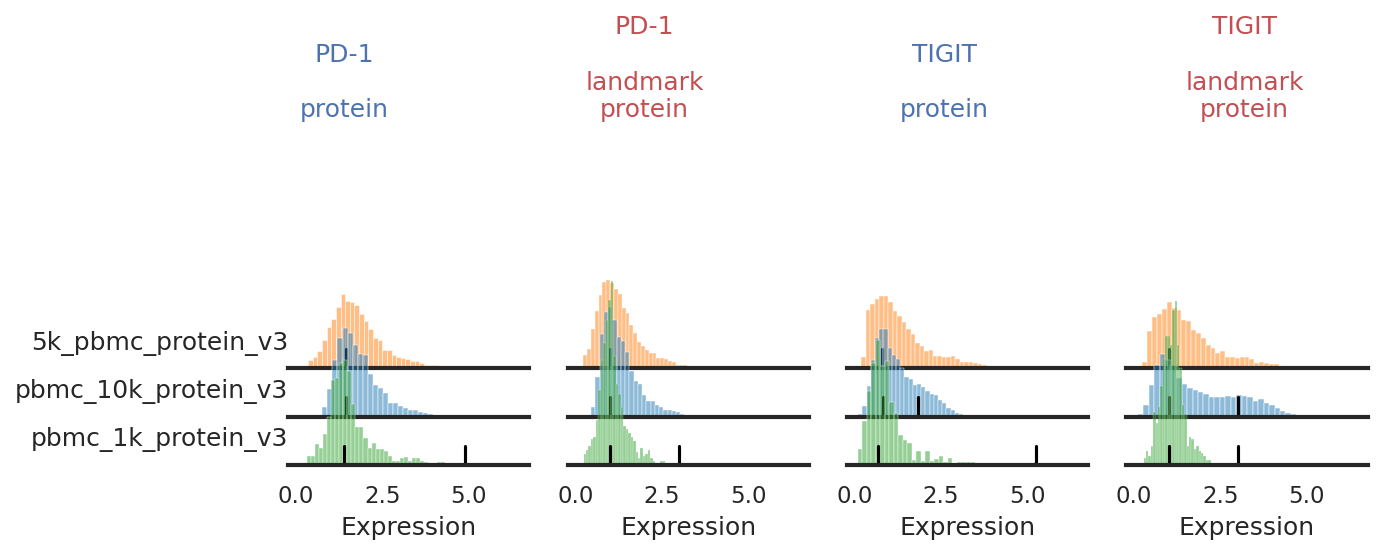

In [5]:
marker_to_process = sorted(adata.obsm['protein'].columns)
chunk_size=3
for i in range(0, len(marker_to_process), chunk_size):
    mmc.stacked_density_plots(adata, marker_to_process[i:i+chunk_size], 'batch', ['protein', 'landmark_protein'], height=1, aspect=2, subsample=1)

For most markers, landmark registration appears to have done a good job. You can see how non-overlapping peaks now sit on top of each other. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;There are caveats to landmark registration. For example, even when applied perfectly, landmark registration will obscure changes in overall expression intensity between samples. Importantly, however, the relative position of the peaks corresponding to cells expressing or lacking any given ADT are now equalized across batches. For thresholding and classification, this is much more important. 

You may also be able to readily identify some spots where peak identification appears to have failed. This includes: 

- [Single peaks](#SinglePeaks) : IgG1_control, IgG2a_control, IgG2b_control
- [Expression gradient](#SinglePeaks) : CD25, PD-1
- [Bandwidth issues](#BandwidthIssues) : CD4, CD45RA
- [Inconsistent peak calling](#Inconsistent): CD56, TIGIT

Below we will take a closer look at each of these cases and identify ways to tweak the algorithm to fix them.

## **Limiting detection to single peaks for unimodal markers and gradients** <a id='SinglePeaks'></a> 
For some markers, most notably our isotype controls, we don't expect to see (nor do we see) a clear positive population. Yet on some batches, the function is accidentally identifying a second peak. 

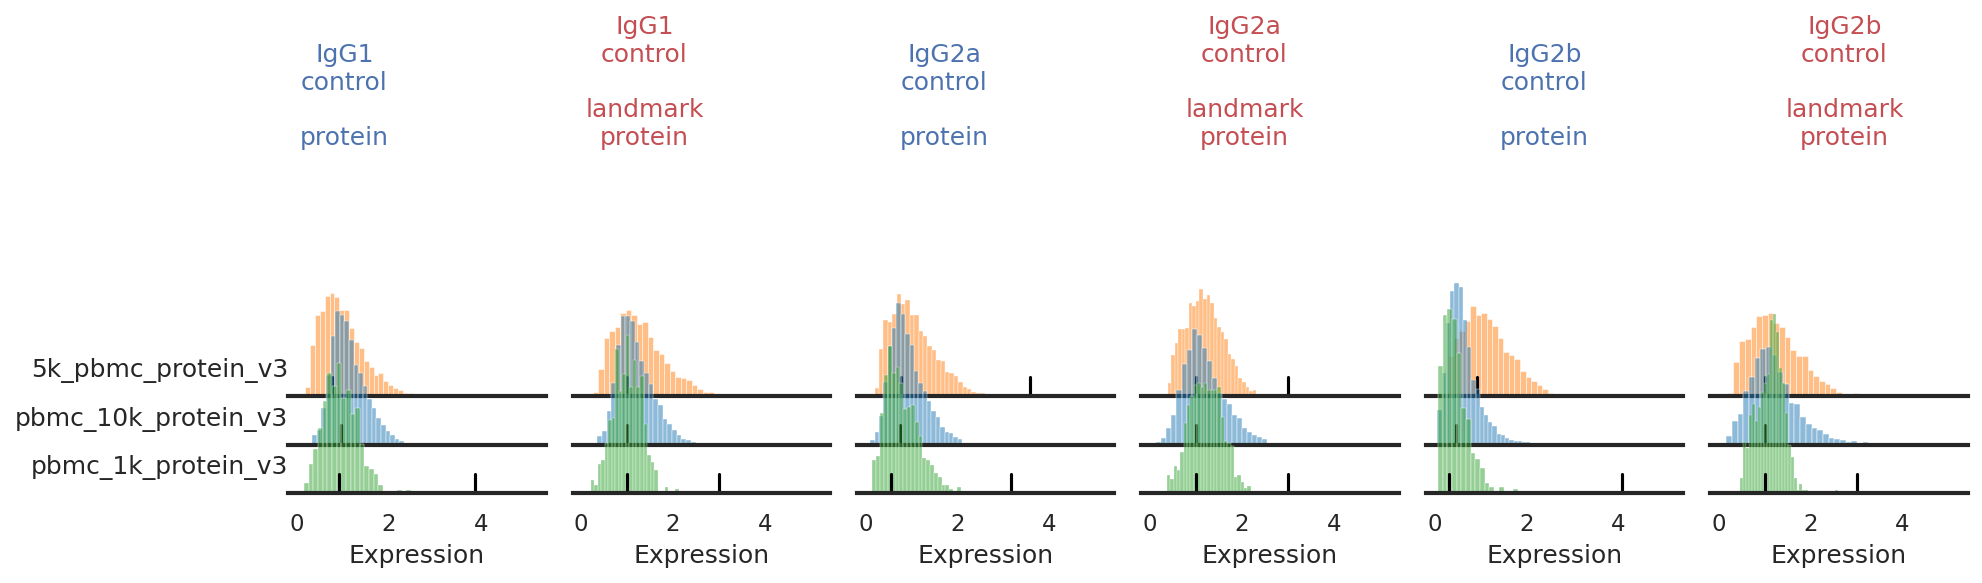

In [6]:
mmc.stacked_density_plots(adata, ['IgG1_control','IgG2a_control','IgG2b_control'], 'batch', ['protein', 'landmark_protein'], height=1, aspect=2, subsample=1)

As an input to `mmc.landmark_register_adts`, we can pass a list of markers that should only have a single peak. Let's create that now, so that later we can eliminate these accidental positive peak calls.

In [7]:
single_peaks = ['IgG1_control','IgG2a_control','IgG2b_control']

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For other markers, there may be a gradient of expression, and it may be hard to define a clear positive or negative peak. For these as well, we may choose to align them as single peaks. This is not the only option for these markers. We could also manually identify two consistent landmarks in the distribution across all the batches, for example clearly low and high expressing populations. These do not necessarily need to be peaks, which for some markers could better reflect how flow-gating is performed.

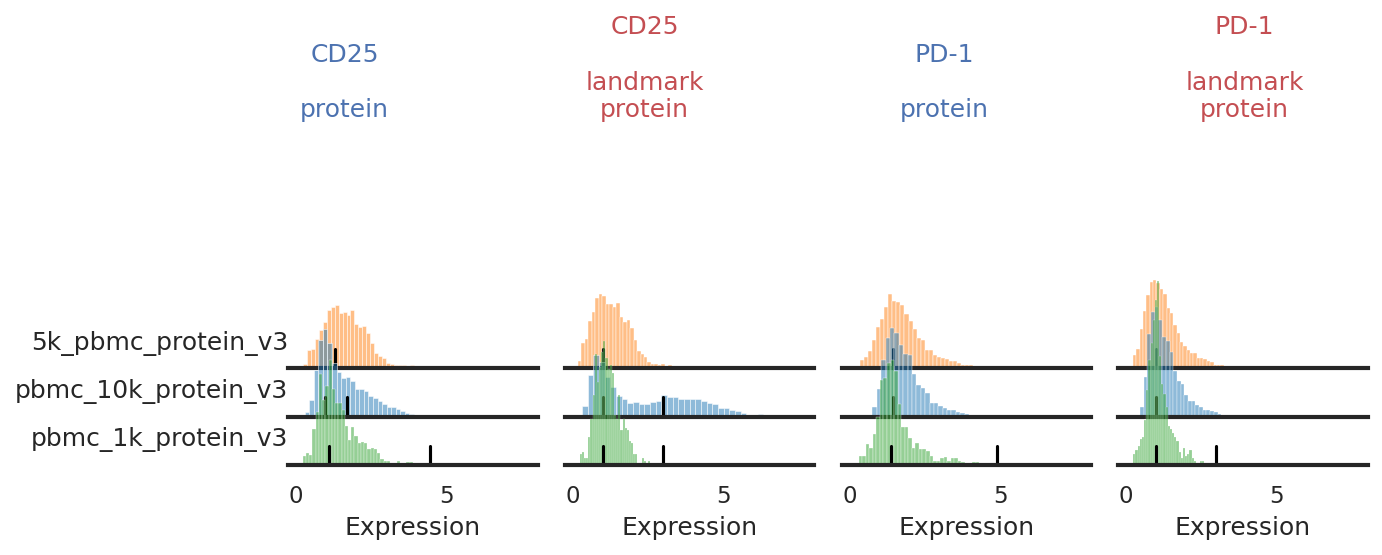

In [8]:
mmc.stacked_density_plots(adata, ['CD25','PD-1'], 'batch', ['protein','landmark_protein'], height=1, aspect=2, subsample=1)

Here, with no clear positive signal, let's just designate them as single-peaks to prevent aberrant alignment:

In [9]:
single_peaks = single_peaks + ['CD25','PD-1']

## **Altering bandwidths** <a id='BandwidthIssues'></a>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For other markers, peak identification appears to have failed across all or most of the batches. Peak identification is performed on the smoothed kernel density estimation (KDE) of the data. The bandwidth parameter controls the level of smoothing performed. Let's see how altering this bandwidth affects peak identification for various markers. Below are our histograms for two trimodal markers: CD4 and CD45RA. 

You can see that for some of these batches, the peak does not sit consistently in the center of the positive population:

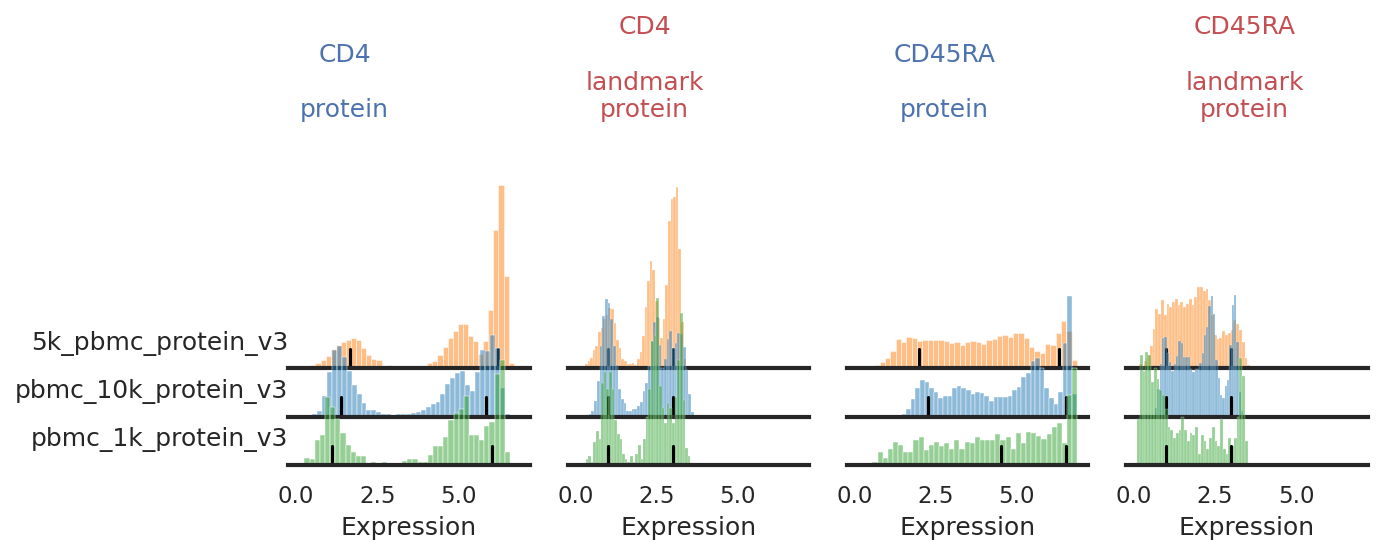

In [10]:
mmc.stacked_density_plots(adata, ['CD4','CD45RA'], 'batch', ['protein','landmark_protein'], height=1, aspect=2)

The default smoothing applied is at a bandwidth adjustment of 0.2, so let's look at that:

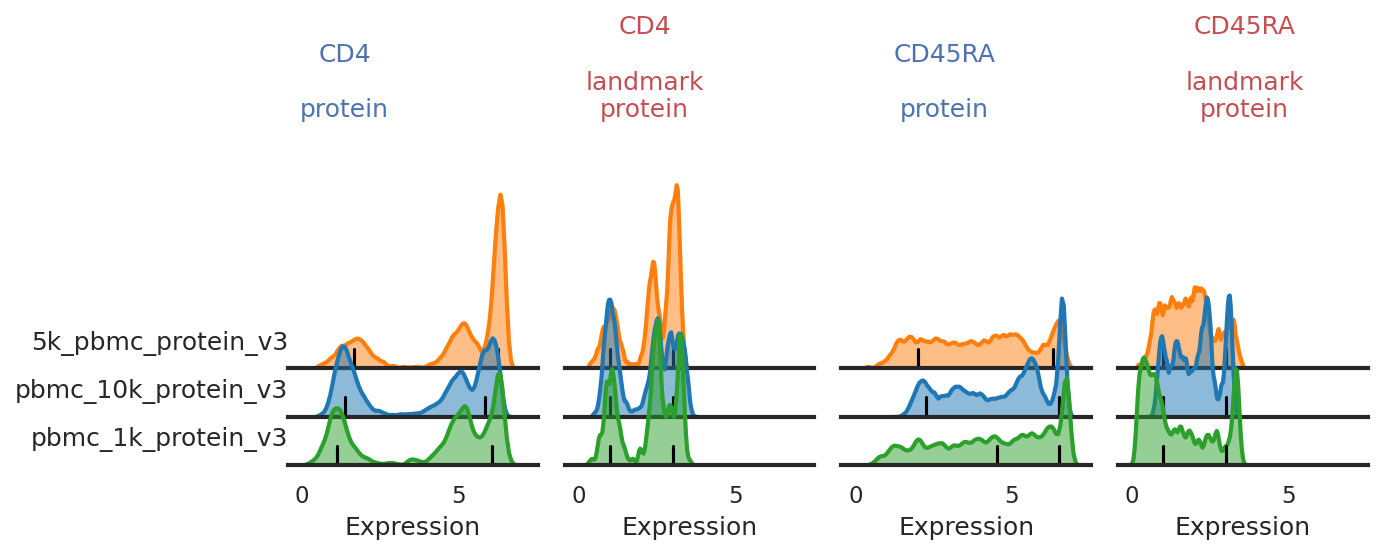

In [11]:
mmc.stacked_density_plots(adata, ['CD4','CD45RA'], 'batch', ['protein', 'landmark_protein'], height=1, aspect=2, bw_adjust=0.2)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;What seems to be happening here is that the positive and mid-peaks are being smoothed together in the KDE approximation, leading to a peak identification that isn't quite centered on the most positive peak. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Let's take an even closer look at `CD4` on each of the batches to see where peak identification is going wrong. As a convenience function, we have also provided `mmc.update_landmark_register` which can recalculate landmark registration on a single marker for a single batch. This can be very handy for quickly seeing how your individual edits affect landmark registration without rerunning the entire dataset. Using `show`, you can also increase verbosity to see more information about the peak detection. 

### The math behind landmark registration

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Increasing verobsity on `mmc.update_landmark_register` reveals a bit of the underlying math to peak detection. While you don't need a complete understanding of the math to apply landmark registration, it may help explain why peak detection fails in some cases, and help you decide which parameters to adjust.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Here we can view the KDE smoothed expression, and the derivative of that function. The red X's identify locations where peaks are called. Peaks are identified using the 1st and 2nd derivatives (slope and change in slope). Yellow dots (not shown here) represent local maxima/minima that were not identified as a 'peak' for various reasons, such as being too close to another identified peak. The green dots identify landmarks identified by the 2nd derivative (maxim or minima in the derivative plot), which could indicate populations that don't quite form a distinct peak.

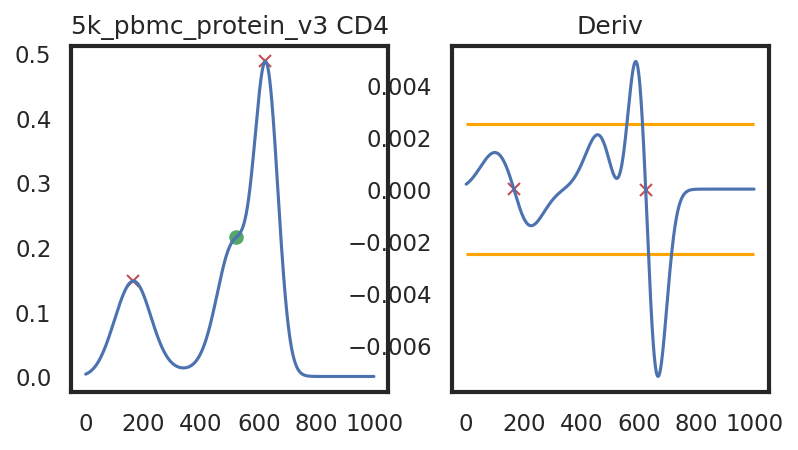

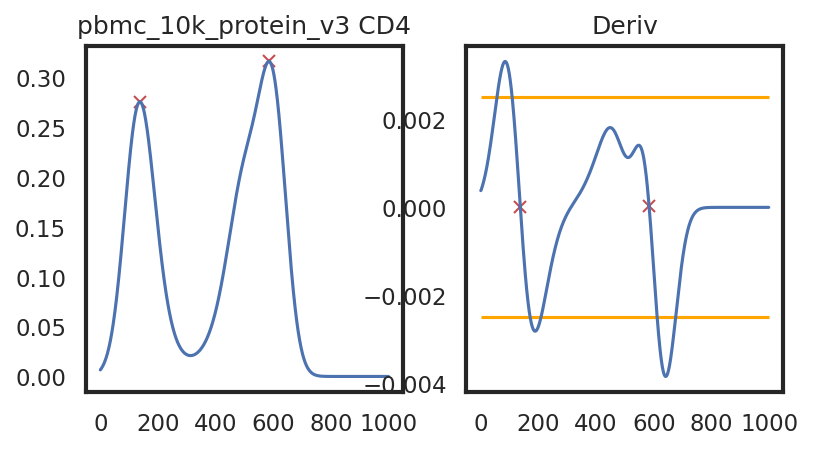

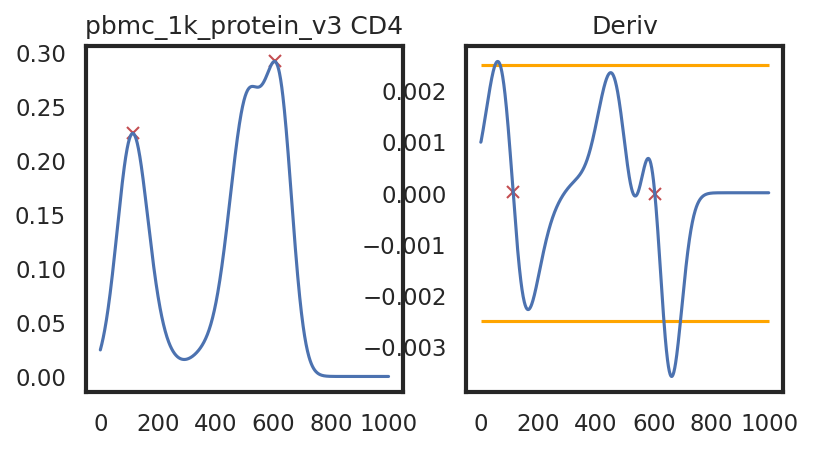

In [12]:
adata = mmc.update_landmark_register(adata, '5k_pbmc_protein_v3', 'CD4', show=2)
adata = mmc.update_landmark_register(adata, 'pbmc_10k_protein_v3', 'CD4', show=2)
adata = mmc.update_landmark_register(adata, 'pbmc_1k_protein_v3', 'CD4', show=2)

As you can see on `pbmc_10k_protein_v3`, it appears that the middle and positive peaks have been merged by the KDE smoothing, leading to a peak identified in between the two of them. The effect this has on the landmark registration is quite minor in this example, but these can have major effects on other samples, so let's look into fixing it by lowering the bandwidth:

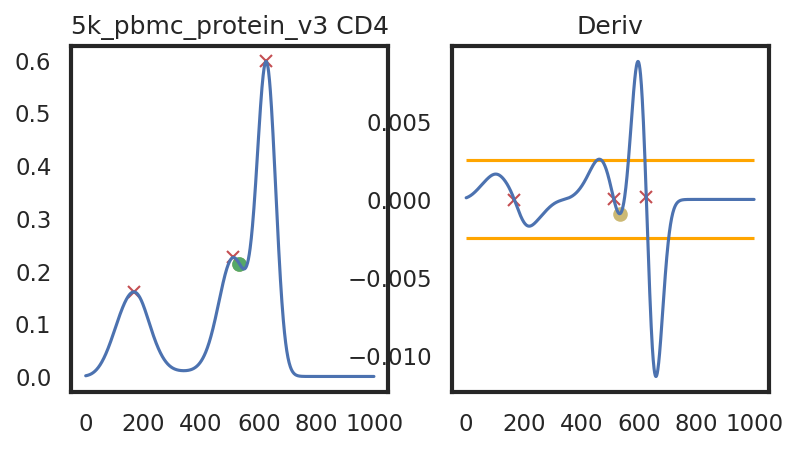

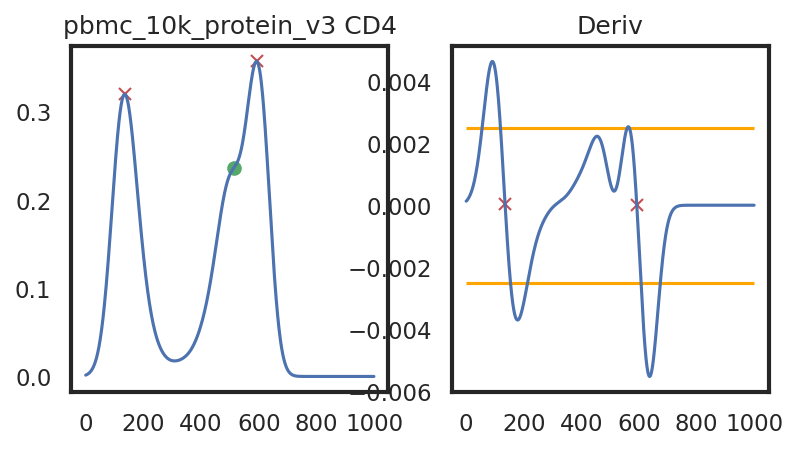

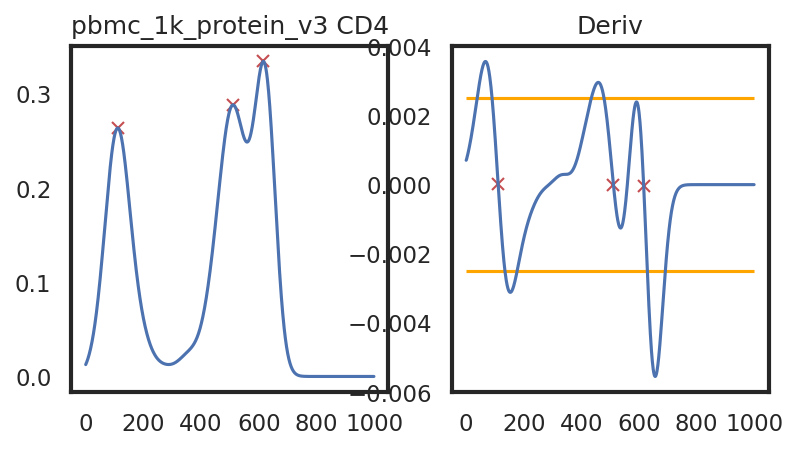

In [13]:
adata = mmc.update_landmark_register(adata, '5k_pbmc_protein_v3', 'CD4', show=2, bandwidth=0.15)
adata = mmc.update_landmark_register(adata, 'pbmc_10k_protein_v3', 'CD4', show=2, bandwidth=0.15)
adata = mmc.update_landmark_register(adata, 'pbmc_1k_protein_v3', 'CD4', show=2, bandwidth=0.15)

So here, changing the bandwidth to a lower number (reducing the amount of smoothing) led to a more correct peak identification. Now let's look into CD45RA:

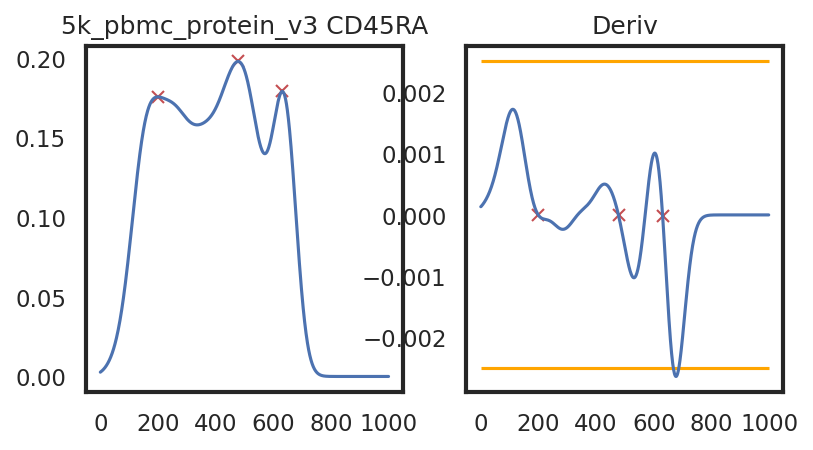

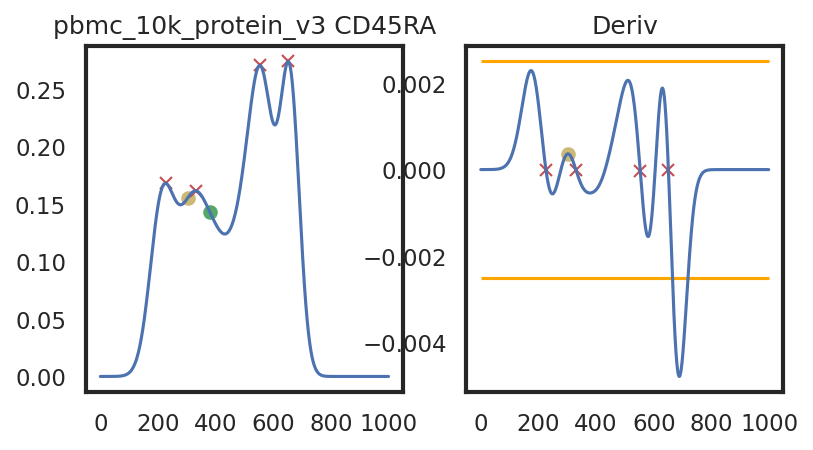

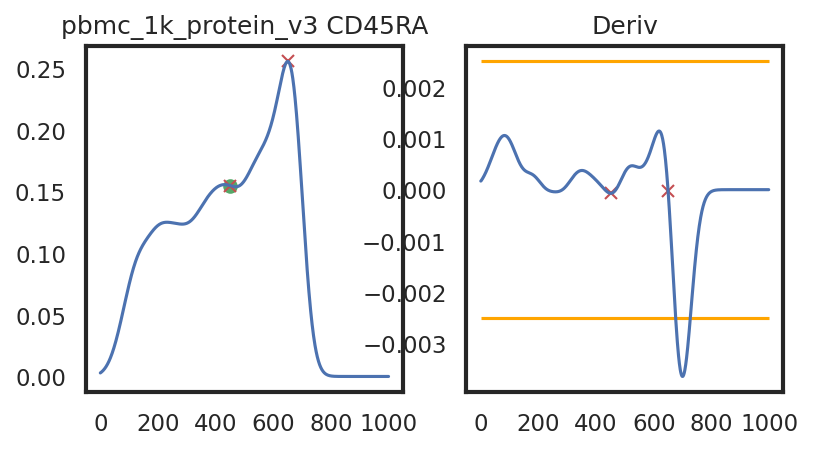

In [14]:
adata = mmc.update_landmark_register(adata, '5k_pbmc_protein_v3', 'CD45RA', show=2)
adata = mmc.update_landmark_register(adata, 'pbmc_10k_protein_v3', 'CD45RA', show=2)
adata = mmc.update_landmark_register(adata, 'pbmc_1k_protein_v3', 'CD45RA', show=2)

Here there's a slightly different issue. On `pbmc_1k_protein_v3`, it appears that the negative peak isn't prominent enough to be identified using this KDE-smoothing. Let's try out a different bandwidth to see if this can be fixed.

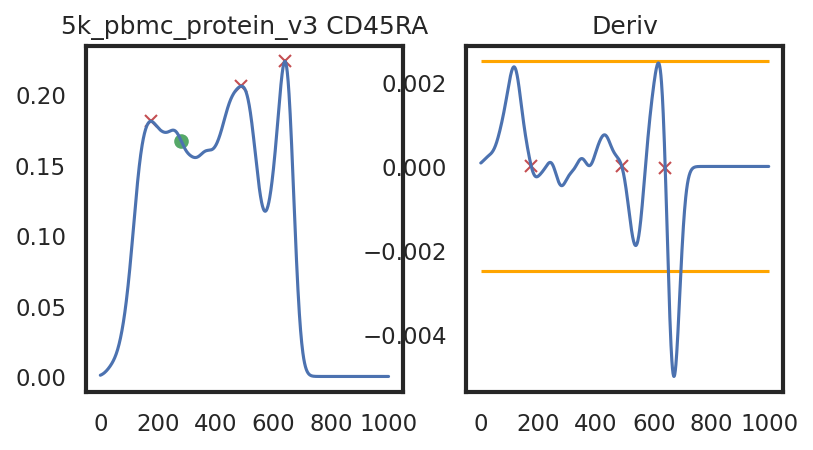

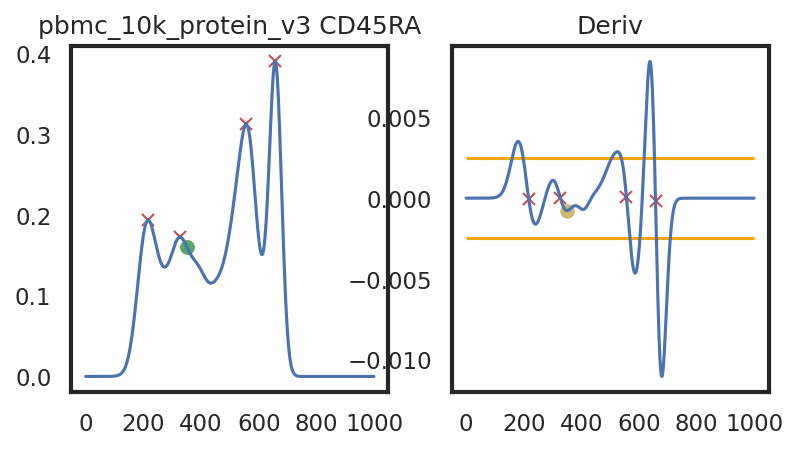

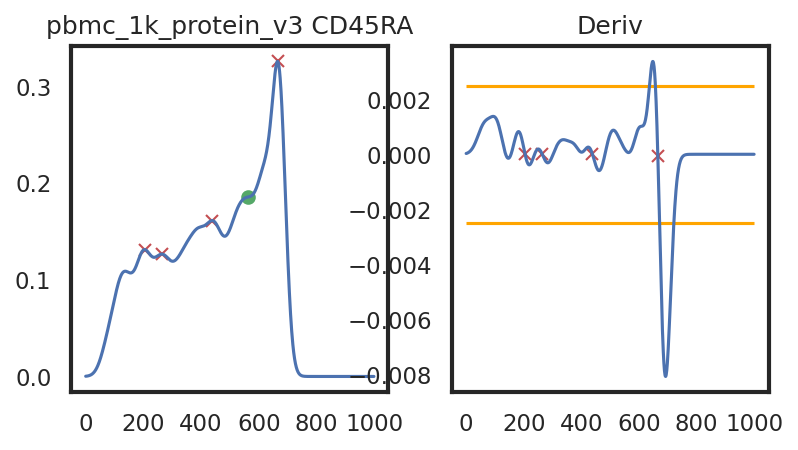

In [15]:
adata = mmc.update_landmark_register(adata, '5k_pbmc_protein_v3', 'CD45RA', show=2, bandwidth=0.12)
adata = mmc.update_landmark_register(adata, 'pbmc_10k_protein_v3', 'CD45RA', show=2, bandwidth=0.12)
adata = mmc.update_landmark_register(adata, 'pbmc_1k_protein_v3', 'CD45RA',show=2, bandwidth=0.12)

Now you can see that these markers are both aligned much more consistently across batches!

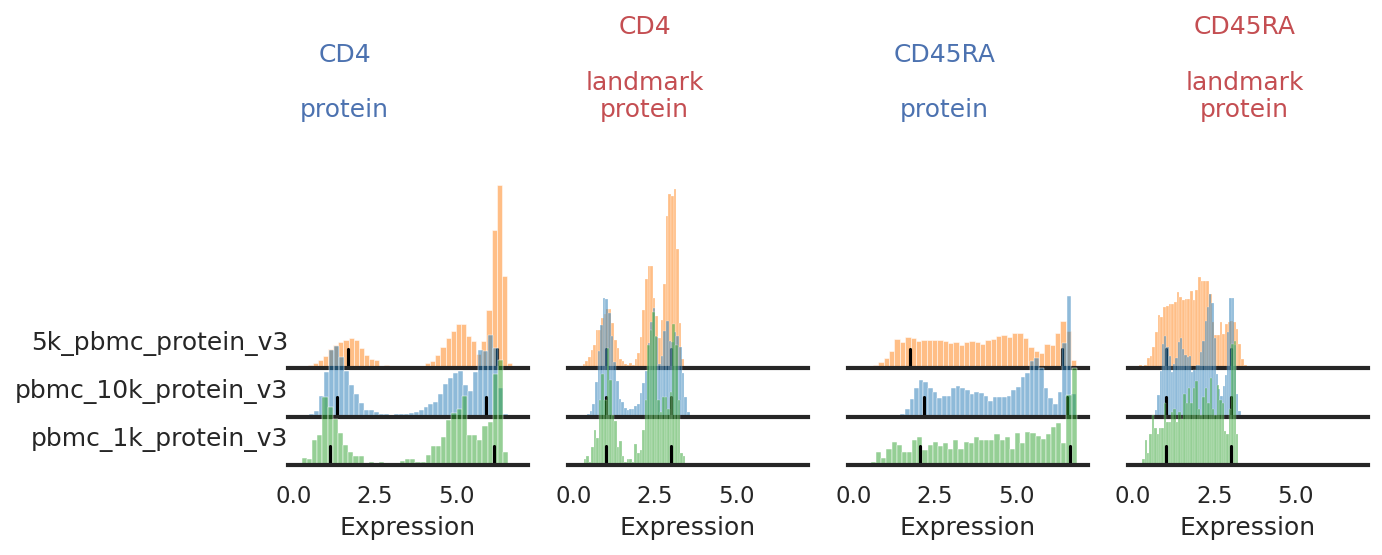

In [16]:
mmc.stacked_density_plots(adata, ['CD4','CD45RA'], 'batch', ['protein', 'landmark_protein'], height=1, aspect=2)

Once we have identified good bandwidths to use, we need to store these in a dictionary to pass to `landmark_register_adts` for our next run. We can format a dictionary as such:

In [17]:
marker_bandwidths = {'CD4':0.15, 'CD45RA':0.12}

## **Manual Overrides** <a id='Inconsistent'></a> 

With these two tools above, you can adjust peak identification pretty effectively across the dataset. Sometimes, however, your eyes and biological insight can do a much better job than our hardcoded algorithm will ever do. In those cases, you need to use manual overrides, and identify the landmarks (peaks) you want the algorithm to align. We begin by creating an empty dictionary to store our overrides:

In [18]:
peak_overrides = {}

Let's take another look at the markers we identified as issues. Here, most of the issues stem from too-few events in `pbmc_1k_protein_v3` expressing these proteins at high levels:

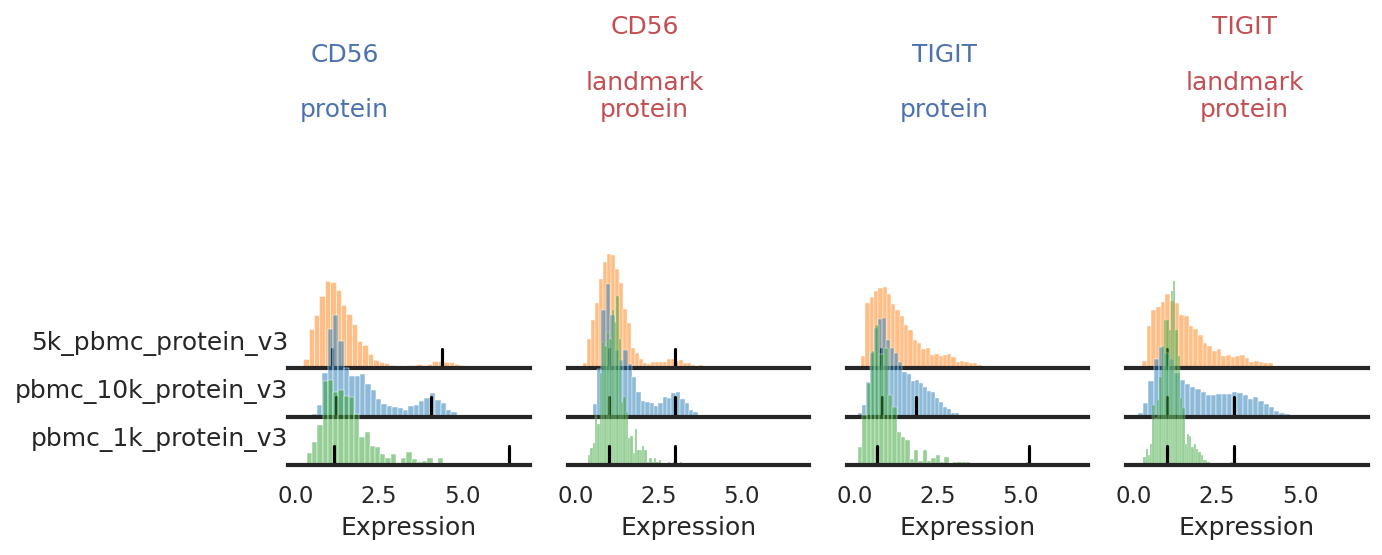

In [19]:
mmc.stacked_density_plots(adata, ['CD56','TIGIT'], 'batch', ['protein', 'landmark_protein'], height=1, aspect=2)

This is the most tedious part of landmark registration, so I have built a list of codeblocks that can be run sequentially to get through this quickly:

In [20]:
marker_name = 'CD56' # TIGIT

In [21]:
# View current peak overrides on that marker across all batches
for b in sorted(peak_overrides.keys()):
    if marker in peak_overrides[b]:
        print(b, peak_overrides[b][marker])

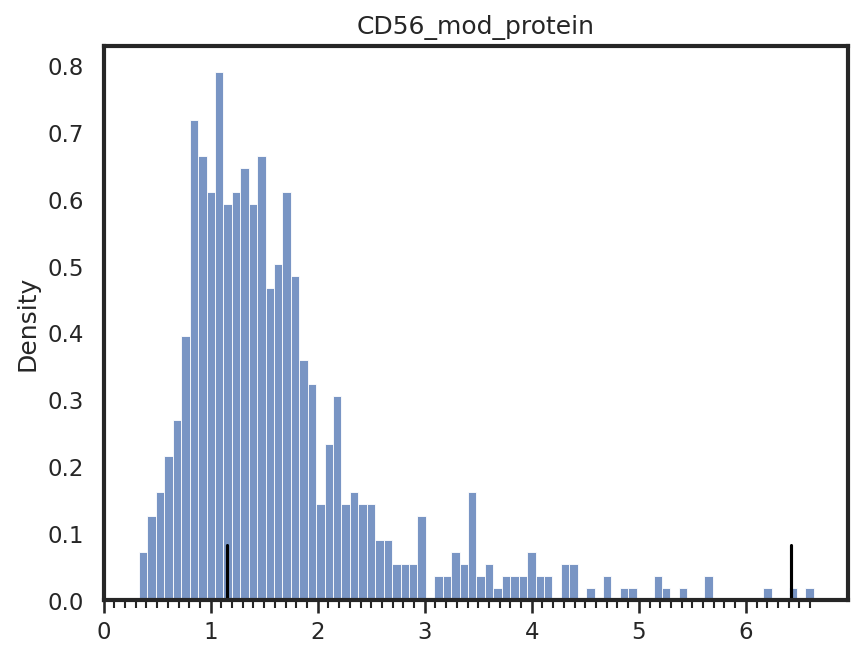

The current peaks sit at [1.1511511511511512, 6.426426426426427]


In [22]:
# Pick a batch, and view a close-up of its original peak identification
batch_name = 'pbmc_1k_protein_v3'
mmc.density_plot(adata, marker_name, batch_name, data_key='protein', bw_adjust=0, step=0.1)
print(f"The current peaks sit at {adata.uns['protein_peaks'][batch_name][marker_name]}")

In [23]:
# Update the peak overrides. To keep current upper or lower peak use False.
# To force a single negative or positive peak, use None for update_upper or update_lower, respectively
peak_overrides = mmc.update_peak_overrides(batch_name, marker_name, update_lower=False, update_upper=3.5, peak_overrides=peak_overrides,
                                           current_peaks=adata.uns['protein_peaks'])
print(f"Set peak_overrides['{batch_name}']['{marker_name}'] = {peak_overrides[batch_name][marker_name]}")

Set peak_overrides['pbmc_1k_protein_v3']['CD56'] = [1.1511511511511512, 3.5]


In [24]:
adata = mmc.update_landmark_register(adata, batch_name, marker_name, override=peak_overrides, 
                            data_key = 'protein', key_added = 'landmark_protein', show=False, 
                            single_peak=single_peaks, bandwidth=marker_bandwidths if marker_name in marker_bandwidths else 0.2)

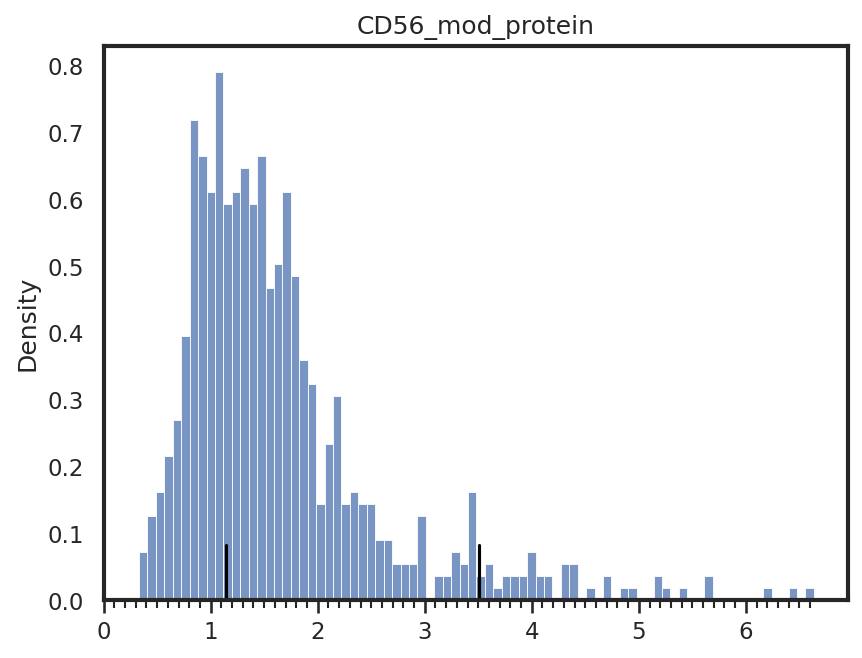

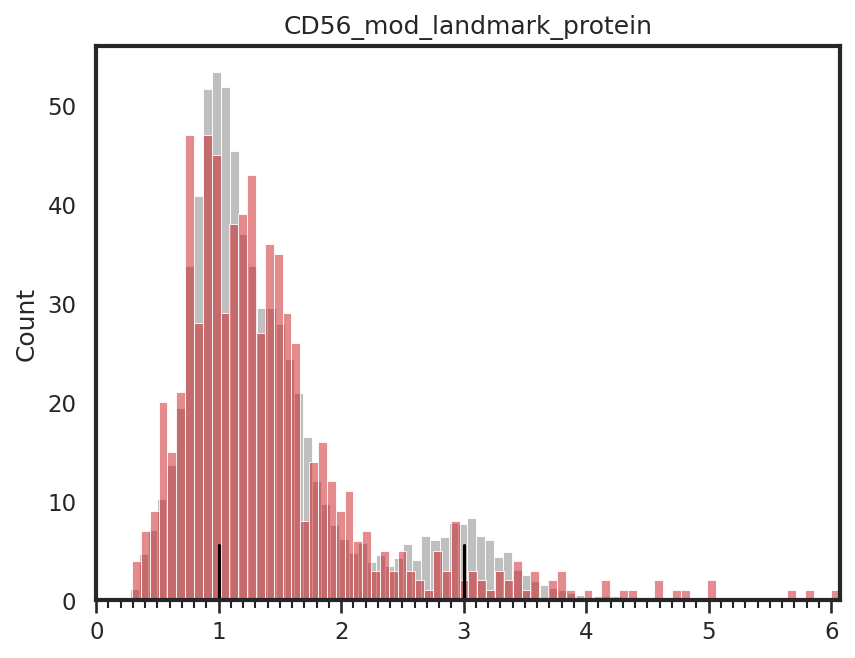

In [25]:
# Display the protein peak identification, and the landmark registration atop all the other batches
mmc.density_plot(adata[adata.obsm['protein'][marker_name]>0], marker_name, batch_name, 'batch', 'protein', bw_adjust=0, step=0.1)
mmc.density_plot_total(adata, marker_name, batch_name, 'batch', 'landmark_protein')

In [26]:
if False: # Alternatively, to remove an override
    del peak_overrides[batch_name][marker_name]

In [27]:
# Print to notebook to have a temporary save of the updated variables, to quickly revert changes, or for updating above.
print('peak_overrides =', peak_overrides, end='\n\n')
print('single_peaks =', single_peaks, end='\n\n')
print('marker_bandwidths =', marker_bandwidths)

peak_overrides = {'pbmc_1k_protein_v3': {'CD56': [1.1511511511511512, 3.5]}}

single_peaks = ['IgG1_control', 'IgG2a_control', 'IgG2b_control', 'CD25', 'PD-1']

marker_bandwidths = {'CD4': 0.15, 'CD45RA': 0.12}


These peak overrides can get quite long, especially with many batches, or large TotalSeq cocktails of ADTs, so we've also implemented a function to save these to a json and load them back in:

In [28]:
mmc.save_peak_overrides('data/overrides.json', peak_overrides)
loaded_overrides = mmc.load_peak_overrides('data/overrides.json')

Great, now go back up and do the same for `TIGIT` on this batch, and on `5k_pbmc_protein_v3`

This is code you can run through iteratively as you evaluate the performance of your landmark registration. 

<div class="alert alert-info">
    
**Tip — Cleaning up more:**
    
Have you identified any other issues in the landmark registration above (e.g. on other markers or batches)? If so, you can edit them here as well! I've written this document to try to provide a good framework for what to look for. Look into the documentation of each of these functions as well to get a better idea what altering each parameter does.</div>

## **Running it all together**
Now that we've made all these modifications, let's put it all together and rerun landmark registration! I've defined all my overrides here so that you can run the next function and get the same output as me.

In [29]:
peak_overrides = {'pbmc_1k_protein_v3': {'CD56': [1.1411411411411412, 3.5], 
                                            'TIGIT': [0.6806806806806807, 2.5]}, 
                  '5k_pbmc_protein_v3': {'TIGIT': [0.8008008008008007, 2.9]}}

single_peaks = ['IgG1_control', 'IgG2a_control', 'IgG2b_control', 'CD25']
marker_bandwidths = {'CD4': 0.15, 'CD45RA': 0.12}

In [30]:
adata = mmc.landmark_register_adts(adata, data_key='protein', single_peaks=single_peaks,
                                   marker_bandwidths=marker_bandwidths, peak_overrides=peak_overrides)

Running with batch batch


  0%|          | 0/3 [00:00<?, ?it/s]

Once the landmark registration has run, this code block will again plot all the ADTs in alphabetical order:

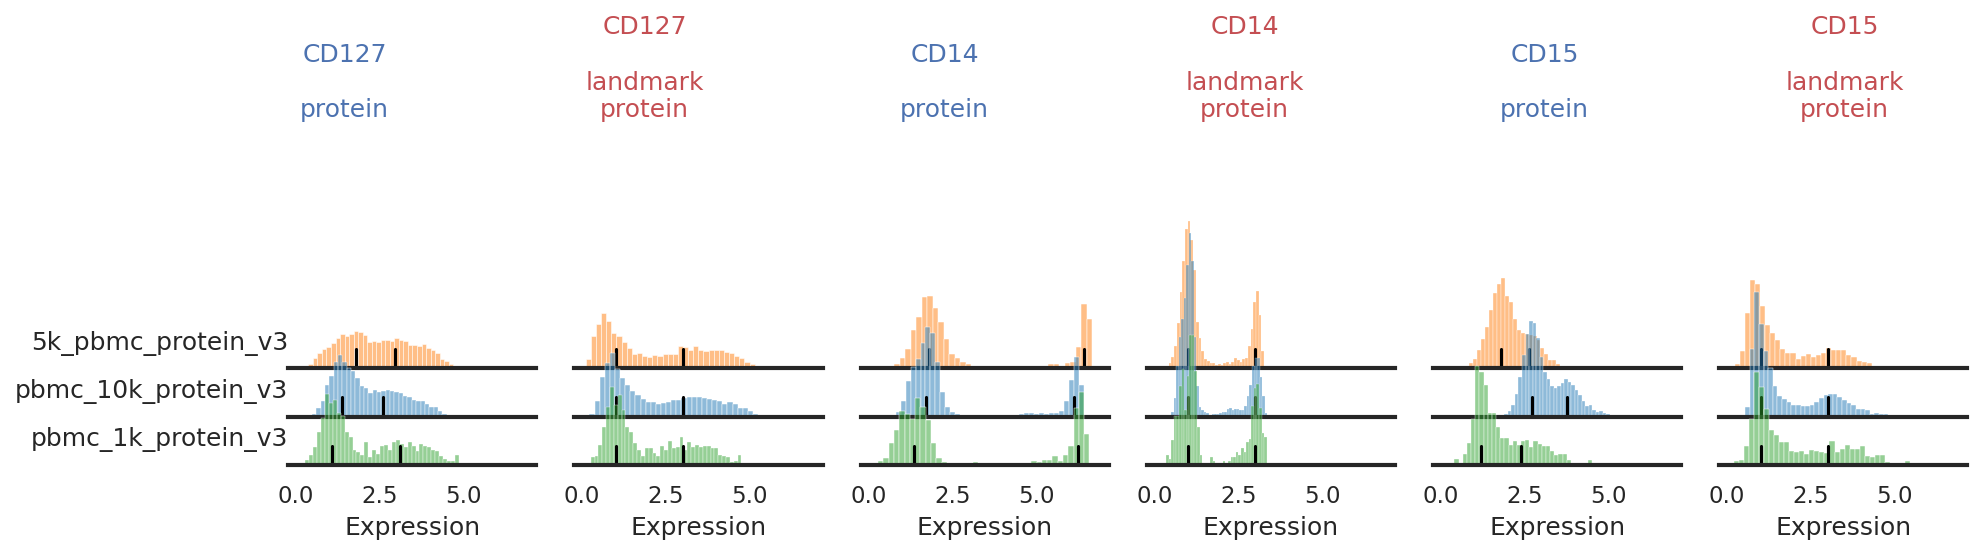

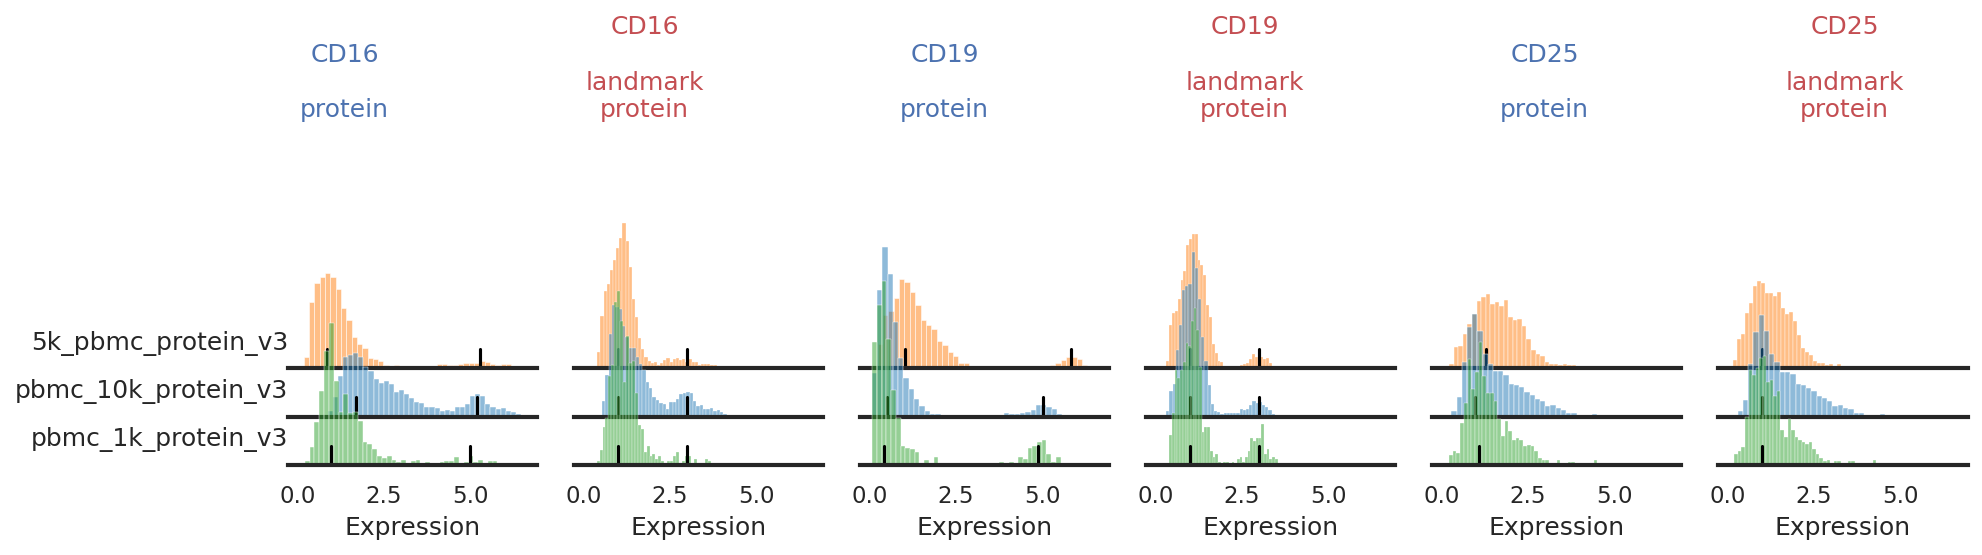

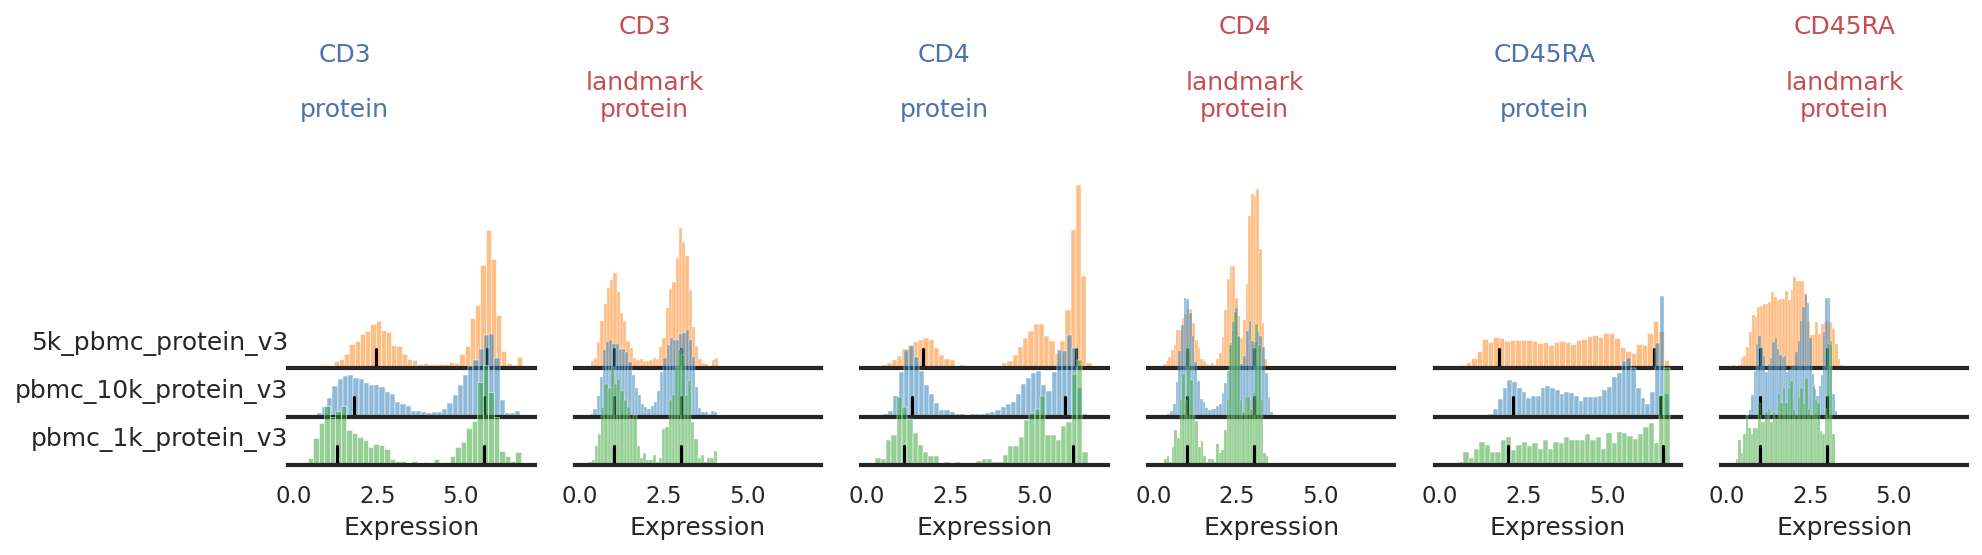

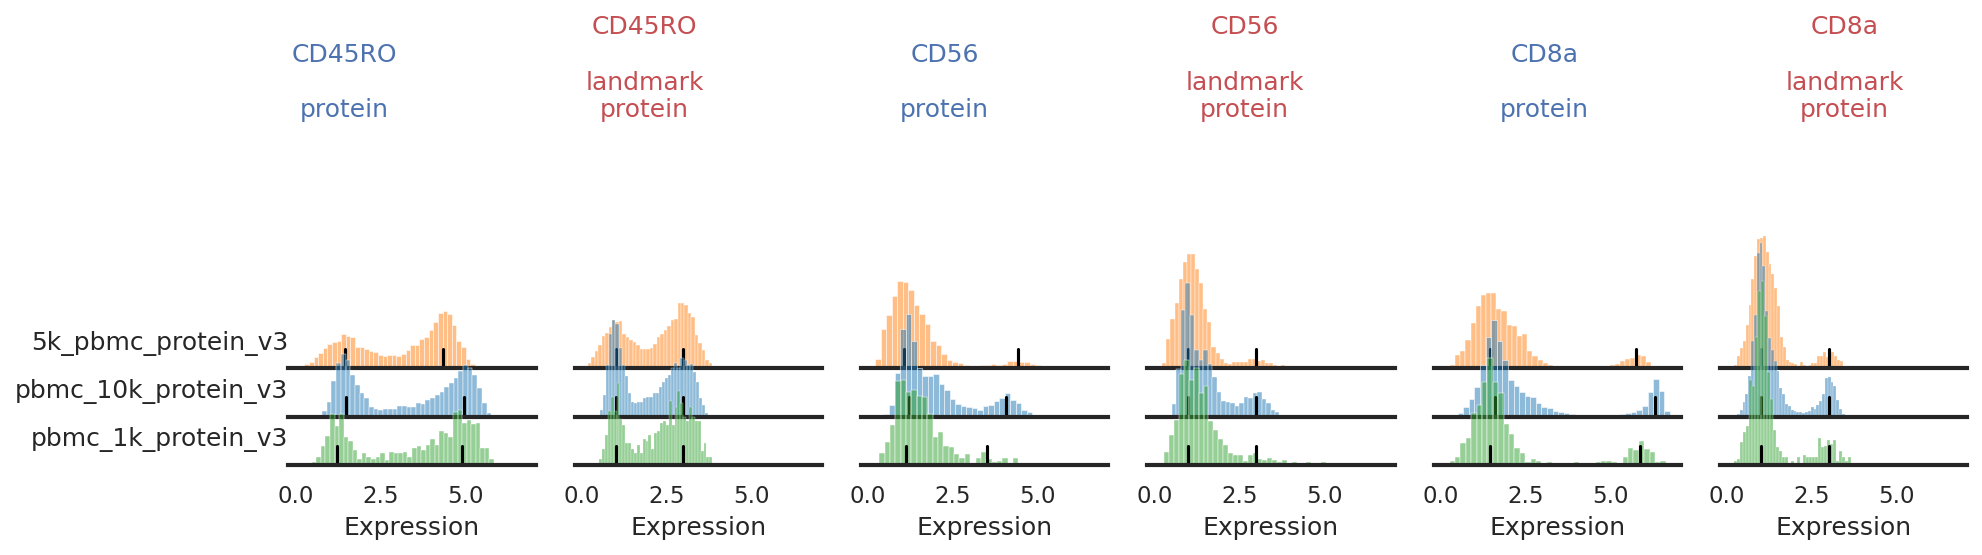

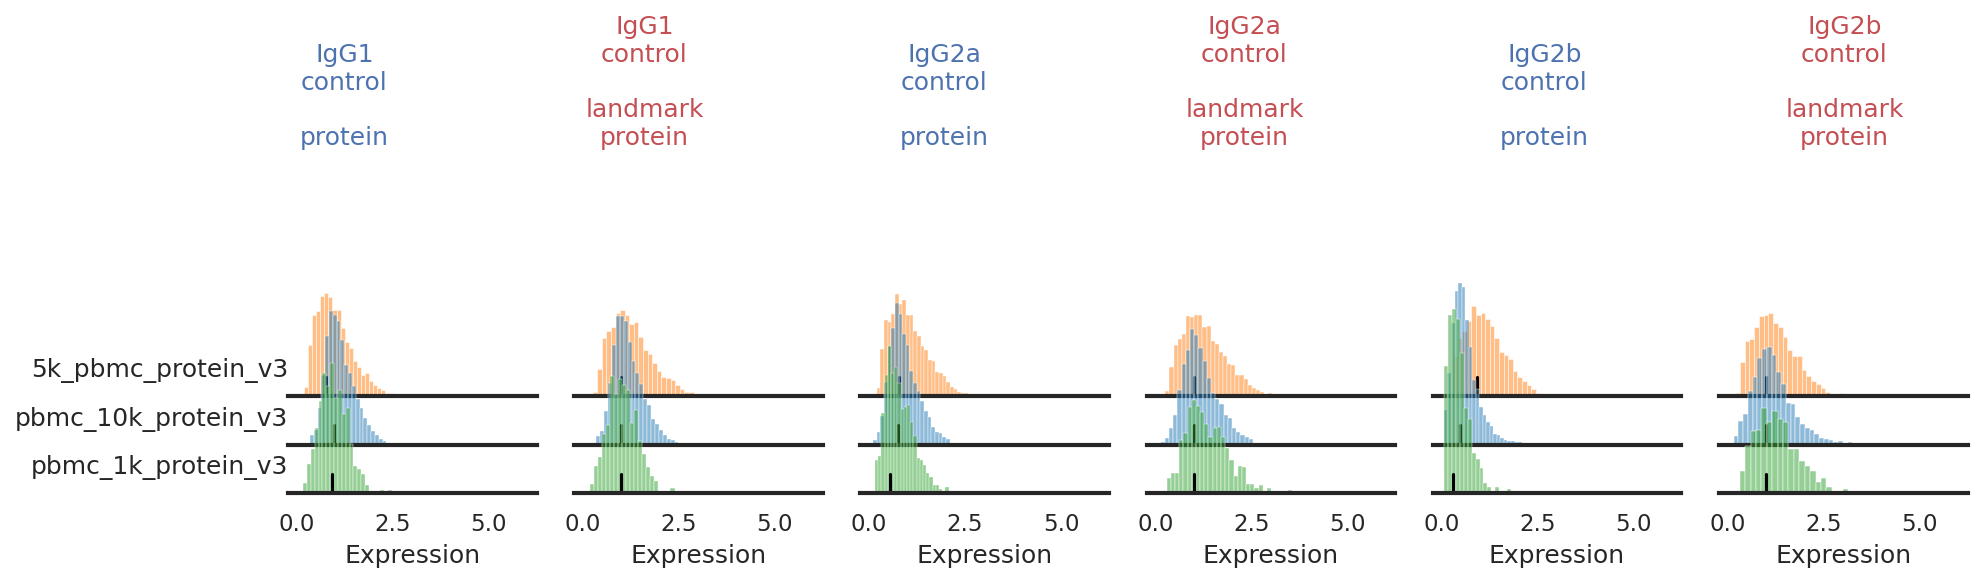

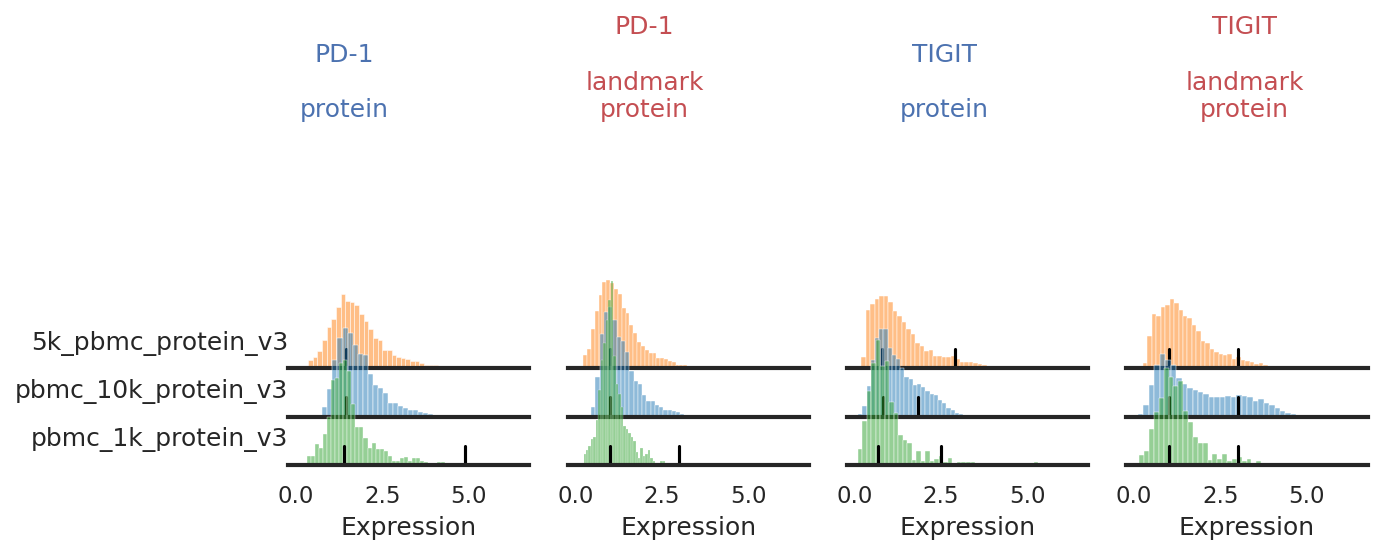

In [31]:
marker_to_process = sorted(adata.obsm['protein'].columns)
chunk_size=3
for i in range(0, len(marker_to_process), chunk_size):
    mmc.stacked_density_plots(adata, marker_to_process[i:i+chunk_size], 'batch', ['protein', 'landmark_protein'], height=1, aspect=2, subsample=1)

<div class="alert alert-success">
    
**Great!** 

This looks much improved and will perform better when we run MMoCHi on it!<br>
</div>